In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sktime.datasets import load_from_ucr_tsv_to_dataframe

from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier

from sklearn.metrics import accuracy_score

from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask

from sktime.series_as_features.model_selection import PresplitFilesCV



In [10]:
import numpy as np
intervals = np.zeros((10, 3), dtype=[(int, int, object)])
print(intervals)

#intervals[0][0] = [1,2]

#print(intervals[0][0])

TypeError: First element of field tuple is neither a tuple nor str

In [ ]:
def benchmark_clf(clf, dataset):
    result = pd.DataFrame(columns=clf[2])
    X_train, y_train = load_from_tsfile(dataset._train_path)
    X_test, y_test = load_from_tsfile(dataset._test_path)

    X_train = from_nested_to_3d_numpy(X_train)
    X_test = from_nested_to_3d_numpy(X_test)

    # Convert class labels to make sure they are between 0,n_classes
    le = LabelEncoder().fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    
    # z normalize data
    #X_train = zscore(X_train, axis=1)
    #X_test = zscore(X_test, axis=1)

    try:
        fit_time = time.process_time()
        clf[0].fit(X_train, y_train)
        fit_time = np.round(time.process_time() - fit_time, 5)

        predict_time = time.process_time()
        y_pred = clf[0].predict(X_test)
        predict_time = np.round(time.process_time() - predict_time, 5)
        
        acc = np.round(accuracy_score(y_test, y_pred), 5)
        try:
            feature_count = clf[0].feature_count * clf[0].num_of_random_dilations
        except:
            feature_count = "NULL"
        result.loc[len(result)] = [clf[1], dataset.name, acc, fit_time, predict_time, feature_count] + clf[3]
        
        print(f"clf {clf[1]} dataset {dataset.name} done")
    except Exception as e:
        print(f"ERROR {e} for dataset {dataset.name} clf {clf[1]}")
    return result



def benchmark(clfs, datasets):
    for clf in clfs:
        results = pd.concat(Parallel(n_jobs=-1)(delayed(benchmark_clf)(clf, dataset)for dataset in datasets), ignore_index=True)
        results_from_clf = results.loc[results["Classifier"] == clf[1]]
        av_acc = results_from_clf["Accuracy"].mean()
        av_fit_time = results_from_clf["Fit-Time"].mean()
        av_pred_time = results_from_clf["Predict-Time"].mean()
        feature_count = results_from_clf["total_feature_count"].iat[0]

        av_results = pd.DataFrame(columns=clf[2])
        av_results.loc[len(av_results)] = [clf[1], "ALL_AVERAGE", av_acc, av_fit_time, av_pred_time, feature_count] + clf[3]

        results = pd.concat([results, av_results], ignore_index=True)

        if not os.path.isfile("./results/" + clf[1] + "_results.csv"):
            results.to_csv("./results/" + clf[1] + "_results.csv", header=True)
        else:
            results.to_csv("./results/" + clf[1] + "_results.csv", mode='a', header=False)
        print(f"clf {clf[1]} done")
        print(av_results[['Classifier', 'Accuracy', 'Fit-Time', 'Predict-Time', 'total_feature_count']])
        results = results[0:0]
        av_results = av_results[0:0]

In [10]:
import numpy as np
X_data = np.array([[-1.7191528, -1.7508808, -1.7962728, -1.8413449, -1.8842889,
        -1.9053929, -1.9239049, -1.9091529],
       [-1.5399724, -1.59015  , -1.6356635, -1.6399894, -1.6786829,
        -1.7292269, -1.7756704, -1.7893245]])
print(X_data.shape)
# in Testdaten ist der shape (36,1,251) -> 36 Timeseries, 251 
d_dilation = 2

#X_data = X_data.squeeze(1)
print(X_data)

X_slice = X_data[:, 1 : 3]

print(X_slice)

def dilation(X, d):
  first = X[:, 0::d]
  for i in range(1, d):
    second = X[:, i::d]
    first = np.concatenate((first, second), axis=1)
    return first
    
print(dilation(X_data, d_dilation))

(2, 8)
[[-1.7191528 -1.7508808 -1.7962728 -1.8413449 -1.8842889 -1.9053929
  -1.9239049 -1.9091529]
 [-1.5399724 -1.59015   -1.6356635 -1.6399894 -1.6786829 -1.7292269
  -1.7756704 -1.7893245]]
[[-1.7508808 -1.7962728]
 [-1.59015   -1.6356635]]
[[-1.7191528 -1.7962728 -1.8842889 -1.9239049 -1.7508808 -1.8413449
  -1.9053929 -1.9091529]
 [-1.5399724 -1.6356635 -1.6786829 -1.7756704 -1.59015   -1.6399894
  -1.7292269 -1.7893245]]


/home/michael/git/sktime_dilation/sktime/benchmarking/base.py:158: UserWarning: Existing results file found in given path: results. Results file will be updated
  warn(


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'accuracy by strategy'}, xlabel='strategies', ylabel='accuracy'>)

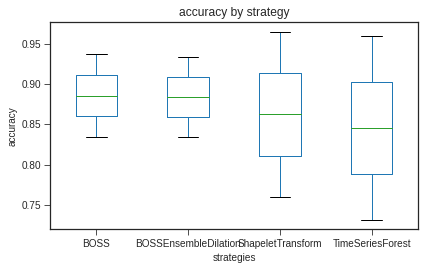

In [3]:

DATA_PATH = "./Univariate_ts"
RESULTS_PATH = "results"

datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=["ArrowHead", "ItalyPowerDemand"]
)

tasks = [TSCTask(target="target") for _ in range(len(datasets))]

strategies = [
    TSCStrategy(BOSSEnsemble(), name="BOSS"),
    TSCStrategy(TimeSeriesForestClassifier(n_estimators=10), name="TimeSeriesForest"),
    TSCStrategy(ShapeletTransformClassifier(), name="ShapeletTransform"),
]

results = HDDResults(path=RESULTS_PATH)

# run orchestrator
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")


# 1. accuracy
print(evaluator.evaluate(metric=metric))
evaluator.plot_boxplots()
# 2. runtime
print(evaluator.fit_runtime(unit='s'))
# 3. memory


## Single Test ##

In [7]:
DATA_PATH = "./UCRArchive_2018"

X_train, y_train = load_from_ucr_tsv_to_dataframe(os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TRAIN.tsv"))
X_test, y_test = load_from_ucr_tsv_to_dataframe(os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TEST.tsv"))

# X_train: input: used to train the model
# y_train: output/labels for the training data to adjust the training
# X_test: input: tests the accuracy of the model after the training phase
# y_test: output/labels for the test data. used to test the accuracy between actual and predicted categories

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# labels, counts = np.unique(y_train, return_counts=True)
# print(labels, counts)

# fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
# for label in labels:
#     X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
# plt.legend()
# ax.set(title="Example time series", xlabel="Time")

clf = IndividualBOSS()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

# initialize the classifier object and fit the model on x_train and # y_train
clf = TimeSeriesForestClassifier()
clf.fit(X_train, y_train)

#make predictions and print the accuracy score for performance
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.52
0.7428571428571429


## Set Parameters ##

In [ ]:
dilation_size = 4

## Dilation Step ##

In [ ]:
def dilation(X, d):
    first = X[:, :, 0::d]
    for i in range(1, d):
        second = X[:, :, i::d]
        first = np.concatenate((first, second), axis=2)
    return first

X_train_dilated = dilation(X_train, dilation_size)

# conv shapelet dilation #

In [32]:
from convst.classifiers import R_DST_Ridge
from convst.utils.dataset_utils import load_sktime_dataset_split

from sktime.datasets import load_from_ucr_tsv_to_dataframe
from sktime.datasets import load_from_tsfile

from sktime.datatypes._panel._convert import from_nested_to_3d_numpy

from sklearn.preprocessing import LabelEncoder
# X_train, X_test, y_train, y_test, _ = load_sktime_dataset_split(
#     'ArrowHead', normalize=True
# )

#DATA_PATH = "./UCRArchive_2018"
DATA_PATH = "./Univariate_ts"

qX_train, qy_train = load_from_ucr_tsv_to_dataframe("./UCRArchive_2018/ArrowHead/ArrowHead_TRAIN.tsv")
qX_test, qy_test = load_from_ucr_tsv_to_dataframe("./UCRArchive_2018/ArrowHead/ArrowHead_TEST.tsv")
qX_train = from_nested_to_3d_numpy(qX_train)
qX_test = from_nested_to_3d_numpy(qX_test)

X_train, y_train = load_from_tsfile(
    os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TRAIN.ts")
)
X_test, y_test = load_from_tsfile(
    os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TEST.ts")
)

X_train = from_nested_to_3d_numpy(X_train)
X_test = from_nested_to_3d_numpy(X_test)

#Convert class labels to make sure they are between 0,n_classes
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


print("hi")

# First run may be slow due to numba compilations on the first call. 
# Run a small dataset like GunPoint if this is the first time you call RDST on your system.
# You can change n_shapelets to 1 to make this process faster. The n_jobs parameter can
# also be changed to increase speed once numba compilation are done.

rdst = R_DST_Ridge(n_shapelets=10_000, n_jobs=1).fit(X_train, y_train)

print("Accuracy Score for RDST : {}".format(rdst.score(X_test, y_test)))

hi
Accuracy Score for RDST : 0.8571428571428571


In [ ]:
def convst(datasets):
    for dataset in datasets:
        X_train, y_train = load_from_tsfile(dataset._train_path)
        X_test, y_test = load_from_tsfile(dataset._test_path)

        X_train = from_nested_to_3d_numpy(X_train)
        X_test = from_nested_to_3d_numpy(X_test)

        #Convert class labels to make sure they are between 0,n_classes
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)

        fit_time = time.process_time()
        rdst = R_DST_Ridge(n_shapelets=10_000, n_jobs=1).fit(X_train, y_train)
        fit_time = np.round(time.process_time() - fit_time, 5)

        predict_time = time.process_time()
        x = rdst.predict(X_test)
        predict_time = np.round(time.process_time() - predict_time, 5)

        acc = np.round(accuracy_score(y_test, x), 5)

        print("fit Score for RDST" ,": {}".format(fit_time))
        print("predict Score for RDST" ,": {}".format(predict_time))
        print("Accuracy Score for RDST" ,": {}".format(acc))

def sktime_clfs(datasets):
    tasks = [TSCTask(target="target") for _ in range(len(datasets))]

    strategies = [
        TSCStrategy(BOSSEnsemble(), name="BOSS"),
        #TSCStrategy(BOSSEnsembleDilation(max_dilation=max_d, min_dilation=1), name="BOSSDilation"),
        #TSCStrategy(TimeSeriesForestClassifier(n_estimators=10), name="TimeSeriesForest"),
        #TSCStrategy(ShapeletTransformClassifier(), name="ShapeletTransform"),
        #TSCStrategy(ShapeletTransformClassifierDilation(), name="ShapeletTransformDilation"),
    ]

    results = HDDResults(path=RESULTS_PATH)

    # run orchestrator
    orchestrator = Orchestrator(
        datasets=datasets,
        tasks=tasks,
        strategies=strategies,
        cv=PresplitFilesCV(),
        results=results,
    )
    orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

    evaluator = Evaluator(results)
    metric = PairwiseMetric(func=accuracy_score, name="accuracy")

    # min_max_dilation
    # print("Dilation Size: ", d_size)
    # 1. accuracy
    # accuracy = evaluator.evaluate(metric=metric)
    # evaluator.plot_boxplots()
    # 2. runtime
    t = evaluator.fit_runtime(unit='s')
    print(t)

#convst(datasets=datasets)
#sktime_clfs(datasets=datasets)

In [ ]:
X_train, X_test, y_train, y_test, _ = load_sktime_dataset_split(
    'GunPoint', normalize=True
)

# First run may be slow due to numba compilations on the first call. 
# Run a small dataset like GunPoint if this is the first time you call RDST on your system.
# You can change n_shapelets to 1 to make this process faster. The n_jobs parameter can
# also be changed to increase speed once numba compilation are done.

rdst = R_DST_Ridge(n_shapelets=10_000, n_jobs=1).fit(X_train, y_train)

print("Accuracy Score for RDST : {}".format(rdst.score(X_test, y_test)))